In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


Load Dataset

In [6]:
df = pd.read_csv(r"C:\Users\kshit\Desktop\FoodDeliveryAI\data\Dataset.csv")
df.head()


,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Type_of_order,Type_of_vehicle,Delivery Time_taken(min)
0,4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,Snack,motorcycle,24
1,B379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,Snack,scooter,33
2,5D6D,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,Drinks,motorcycle,26
3,7A6A,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,Buffet,motorcycle,21
4,70A2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,Snack,scooter,30


Basic Inspection

In [7]:
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45593 non-null  object 
 1   Delivery_person_ID           45593 non-null  object 
 2   Delivery_person_Age          45593 non-null  int64  
 3   Delivery_person_Ratings      45593 non-null  float64
 4   Restaurant_latitude          45593 non-null  float64
 5   Restaurant_longitude         45593 non-null  float64
 6   Delivery_location_latitude   45593 non-null  float64
 7   Delivery_location_longitude  45593 non-null  float64
 8   Type_of_order                45593 non-null  object 
 9   Type_of_vehicle              45593 non-null  object 
 10  Delivery Time_taken(min)     45593 non-null  int64  
dtypes: float64(5), int64(2), object(4)
memory usage: 3.8+ MB


ID                             0
Delivery_person_ID             0
Delivery_person_Age            0
Delivery_person_Ratings        0
Restaurant_latitude            0
Restaurant_longitude           0
Delivery_location_latitude     0
Delivery_location_longitude    0
Type_of_order                  0
Type_of_vehicle                0
Delivery Time_taken(min)       0
dtype: int64

In [8]:
(df == 0).sum()


ID                                0
Delivery_person_ID                0
Delivery_person_Age               0
Delivery_person_Ratings           0
Restaurant_latitude            3640
Restaurant_longitude           3640
Delivery_location_latitude        0
Delivery_location_longitude       0
Type_of_order                     0
Type_of_vehicle                   0
Delivery Time_taken(min)          0
dtype: int64

Latitude = 0
Longitude = 0

This is IMPOSSIBLE for India.

India latitude ≈ 8° to 37°
India longitude ≈ 68° to 97°

So these 3640 rows are clearly invalid/missing coordinates.

In [ ]:
df = df[(df["Restaurant_latitude"] != 0) & 
        (df["Restaurant_longitude"] != 0)]

print("New shape:", df.shape)


Remove Duplicates

In [9]:
df.drop_duplicates(inplace=True)
print("After removing duplicates:", df.shape)


After removing duplicates: (45593, 11)


Fix Data Types (Important)

Sometimes ratings come as object.

In [10]:
df["Delivery_person_Ratings"] = pd.to_numeric(
    df["Delivery_person_Ratings"], errors="coerce"
)

df["Delivery_person_Age"] = pd.to_numeric(
    df["Delivery_person_Age"], errors="coerce"
)


Remove Invalid Coordinates :

Restaurant latitude & longitude have 3640 zeros.

In [11]:
df = df[(df["Restaurant_latitude"] != 0) & 
        (df["Restaurant_longitude"] != 0)]


Remove Impossible Values
Age Cleaning

Delivery age should be between 18 and 60.

In [12]:
df = df[(df["Delivery_person_Age"] >= 18) & 
        (df["Delivery_person_Age"] <= 60)]


Rating Cleaning

Ratings should be between 1 and 5.

In [13]:
df = df[(df["Delivery_person_Ratings"] >= 1) & 
        (df["Delivery_person_Ratings"] <= 5)]


Delivery Time Cleaning

Delivery time should not be 0 or negative.

In [14]:
df = df[df["Delivery Time_taken(min)"] > 0]


Remove Outliers (IQR Method)

This makes your model stronger.

In [15]:
Q1 = df["Delivery Time_taken(min)"].quantile(0.25)
Q3 = df["Delivery Time_taken(min)"].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df["Delivery Time_taken(min)"] >= lower_bound) &
        (df["Delivery Time_taken(min)"] <= upper_bound)]


Reset Index

In [16]:
df.reset_index(drop=True, inplace=True)


Final Check

In [17]:
print("Final Shape:", df.shape)
print("\nFinal Missing Values:\n", df.isnull().sum())


Final Shape: (41625, 11)

Final Missing Values:
 ID                             0
Delivery_person_ID             0
Delivery_person_Age            0
Delivery_person_Ratings        0
Restaurant_latitude            0
Restaurant_longitude           0
Delivery_location_latitude     0
Delivery_location_longitude    0
Type_of_order                  0
Type_of_vehicle                0
Delivery Time_taken(min)       0
dtype: int64


Extract City from Delivery_person_ID

In [18]:
df["City"] = df["Delivery_person_ID"].str[:4]


In [19]:
df[["Delivery_person_ID", "City"]].head()


,Delivery_person_ID,City
0,INDORES13DEL02,INDO
1,BANGRES18DEL02,BANG
2,BANGRES19DEL01,BANG
3,COIMBRES13DEL02,COIM
4,CHENRES12DEL01,CHEN


Calculate Real Distance (Haversine)

In [20]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    return R * c

df["distance_km"] = haversine(
    df["Restaurant_latitude"],
    df["Restaurant_longitude"],
    df["Delivery_location_latitude"],
    df["Delivery_location_longitude"]
)


In [21]:
df.drop(columns=[
    "Restaurant_latitude",
    "Restaurant_longitude",
    "Delivery_location_latitude",
    "Delivery_location_longitude"
], inplace=True)


Delivery Efficiency Score

In [22]:
df["efficiency_score"] = (
    df["Delivery_person_Age"] * df["Delivery_person_Ratings"]
)


Vehicle Speed Factor

In [23]:
vehicle_map = {
    "motorcycle": 1.0,
    "scooter": 0.9,
    "electric_scooter": 0.85
}

df["vehicle_speed_factor"] = df["Type_of_vehicle"].map(vehicle_map)


Geographical Clustering 

Cluster restaurant zones.

In [24]:
from sklearn.cluster import KMeans

coords = df[["distance_km"]]
kmeans = KMeans(n_clusters=6, random_state=42)
df["distance_cluster"] = kmeans.fit_predict(coords)


c:\Users\kshit\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\kshit\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\kshit\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 556, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\kshit\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 1038

PHASE 2 — Model Strategy :

We compare:

Random Forest

XGBoost

LightGBM

CatBoost

Best for your dataset = LightGBM or CatBoost

They are:

Fast

Handle categorical features well

Great for tabular data

Train LightGBM

In [26]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

X = df.drop("Delivery Time_taken(min)", axis=1)
y = df["Delivery Time_taken(min)"]

X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=8
)

model.fit(X_train, y_train)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1909
[LightGBM] [Info] Number of data points in the train set: 33300, number of used features: 707
[LightGBM] [Info] Start training from score 26.153153
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

LGBMRegressor(learning_rate=0.03, max_depth=8, n_estimators=1000)

Evaluate Properly

In [27]:
from sklearn.metrics import mean_squared_error, r2_score

pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

print("RMSE:", rmse)
print("R2:", r2)


RMSE: 7.097888787466877
R2: 0.3976146567714097


Add Delay Risk Classifier (UNIQUE EDGE)

Now create another model:

In [ ]:
df["Delay_Risk"] = df["Delivery Time_taken(min)"].apply(
    lambda x: 1 if x > 40 else 0
)
#Train XGBoost classifier.

Explainable AI :

Use SHAP:

c:\Users\kshit\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


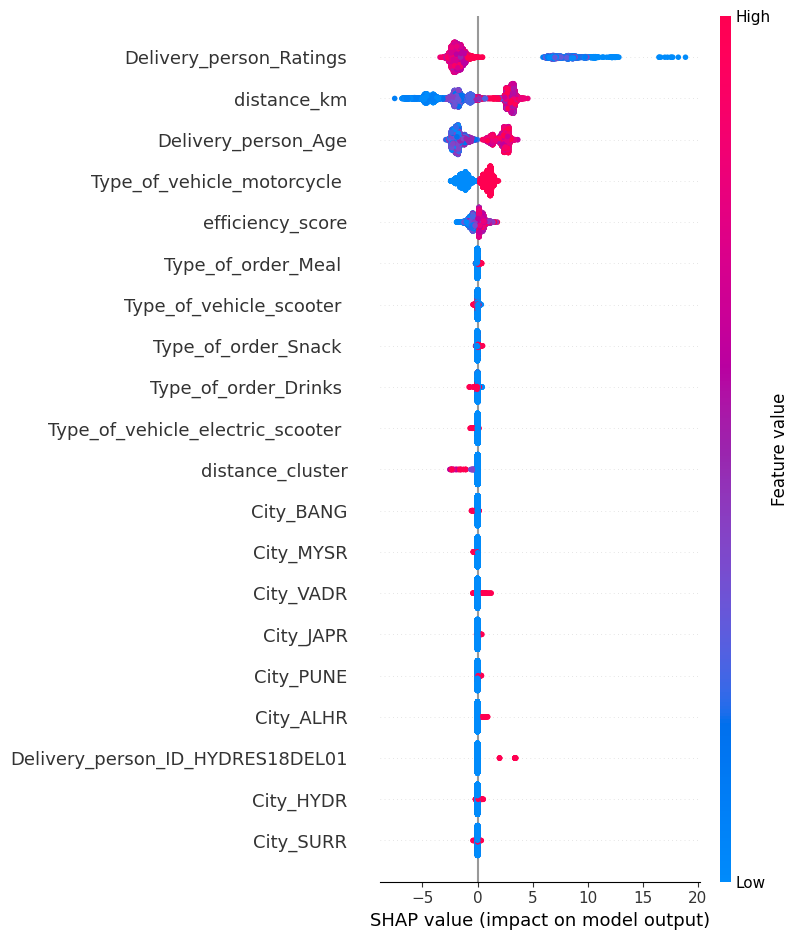

In [29]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)
